In [146]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import pickle

sys.path.append('../')
from RNO_1d import *

In [147]:
def time_deriv_nonper(u, dt):
    """
    Finite difference method to compute time derivative of nonperiodic function
    """
    return (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)

In [169]:
rho_0 = 154
rho_1 = 8
tau = 100

perturb = 50 # how much to perturb parameters by

sigma = lambda t: 10 + perturb
rho = lambda t: rho_0 + rho_1 * np.exp(t / tau) + perturb
beta = lambda t: 8/3 + perturb

def lorenz_deriv(u, t_mins, t_step, sigma=sigma, rho=rho, beta=beta):
    """
    `t_mins` is a 1D tensor of length (batchsize,) that contains the time associated with the minimum t in `u` for
        each element in the batch
    `t_step` is the time step between steps in `u`
    """
    batchsize = u.size(0)
    nt = u.size(1)
    dim = u.size(2)
    
    t_ends = t_mins + nt * t_step
    t_ranges = torch.vstack([torch.arange(start=t_mins[i], end=t_ends[i], step=t_step)[:nt] for i in range(batchsize)])
    assert t_ranges.size(1) == nt
    
    rhs = torch.zeros_like(u)
    
    x = u[:,:,0]
    y = u[:,:,1]
    z = u[:,:,2]
    
    rhs[:, :, 0] = -sigma(t_ranges)*x + sigma(t_ranges)*y
    rhs[:, :, 1] = rho(t_ranges)*x - y - x*z
    rhs[:, :, 2] = -beta(t_ranges)*z + x*y
    
    return rhs

In [170]:
def PDE_loss(u, t_mins, t_step):
    rhs = lorenz_deriv(u, t_mins, t_step)
    rhs = rhs[:,1:-1,:] # match dimensions to output of `time_deriv_nonper`
    
    u_t = time_deriv_nonper(u, t_step)
    
    return torch.mean(torch.norm(u_t - rhs, dim=-1), axis=-1) # time-averaged within each window

In [171]:
def get_index_from_time(T_min, T_max, query_time, arr_size):
    """
    Given array with data spanning from time T_min to T_max, return the index in the array
    associated with query_time.
    """
    time_range = T_max - T_min
    return round(arr_size * (query_time - T_min) / time_range)

In [172]:
def round_down(num, divisor): # rounds `num` down to nearest multiple of `divisor`
    return num - (num % divisor)

# Data loading

We now load the testing data. We will compute the empirical CDF on 4 trajectories and predict the tipping point on a fifth, unseen trajectory.

In [173]:
# Data is of the shape (number of samples, grid size)
with open("nonstationary_lorenz_data_15_trajectories.p", "rb") as file:
    data_dict = pickle.load(file)

tipping_point = 40 # time of tipping point -- (theoretically-determined)

sub = 5
dim = 3
solver_dt = data_dict['dt']
T1 = data_dict['T1']
T2 = data_dict['T2']
data = data_dict['data'][:,::sub]
data = data[:,:-1] # Make shape easier to divide

n_intervals = 5 # number of intervals in each training example

T = 64 # input last T time steps and output next T
sub = 5 # temporal subsampling rate
dt = sub * solver_dt

val_trajectories = 4 # trajectories used for computing eCDF
test_trajectories = 1 # trajectories where we will predict tipping point

# Scaling
train = data[:-5]
train_max = np.max(train, axis=(0,1))
train_min = np.min(train, axis=(0,1))

data = data[-5:]
val = data[:val_trajectories]
test = data[-test_trajectories:]

# Empirical CDF Analysis

In [174]:
comp_steps = 200 # number of steps to compose model
comp_offset = comp_steps * dt * T

pde_loss_samples = []

### Data processing

In [175]:
# Tipping point adjusted for number of composition steps `comp_steps`
adjusted_tipping_point = tipping_point - comp_offset

tipping_idx = round_down(get_index_from_time(T1, T2, adjusted_tipping_point, test.shape[1]), T * dim)
pre_tipping_val = val[:,:tipping_idx]

pre_tipping_val = np.reshape(pre_tipping_val, (val_trajectories, -1, T, dim))
test = np.reshape(test, (test_trajectories, -1, T, dim))

# Generate input time-steps
pre_tipping_val_list = []
test_list = []

for traj in pre_tipping_val:
    traj_list = []
    for i in range(pre_tipping_val.shape[1] - n_intervals - 1): # - 1 to make sure the y value exists
        traj_list.append(traj[i:i + n_intervals])
        
    pre_tipping_val_list.append(traj_list)

for traj in test:
    traj_list = []
    for i in range(test.shape[1] - n_intervals - 1):
        traj_list.append(traj[i:i + n_intervals])
    
    test_list.append(traj_list)

pre_tipping_val = np.array(pre_tipping_val_list)
test = np.array(test_list)

pre_tipping_val = torch.tensor(pre_tipping_val).float()
test = torch.tensor(test).float()

### Computing eCDF

In [176]:
model = torch.load('PATH/TO/MODEL', map_location=torch.device('cpu'))

In [177]:
model.eval()

with torch.no_grad():
    for x_batch in tqdm(pre_tipping_val): # compute eCDF on validation set
        t_mins = np.arange(T1, T2, T * dt)[:x_batch.shape[0]] + n_intervals * T * dt
        
        u = model.predict(x_batch, comp_steps)
        u = u.reshape((x_batch.shape[0], -1, dim))
        
        pde_loss_samples.append(PDE_loss(u, t_mins, dt).numpy())
        
pde_loss_samples = np.array(pde_loss_samples).flatten()

100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [09:04<00:00, 136.09s/it]


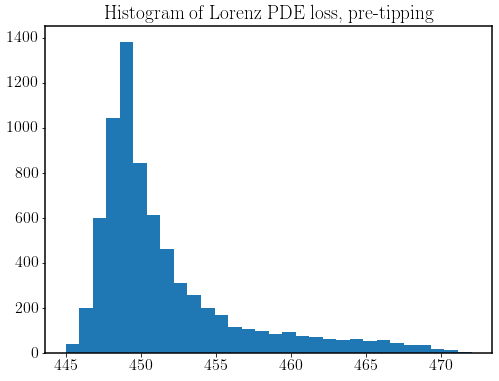

In [216]:
plt.figure(figsize=(8,6))
plt.hist(pde_loss_samples, bins=30)
plt.title("Histogram of Lorenz PDE loss, pre-tipping")
plt.show()

In [217]:
ecdf = lambda x: np.sum(pde_loss_samples < x) / len(pde_loss_samples)

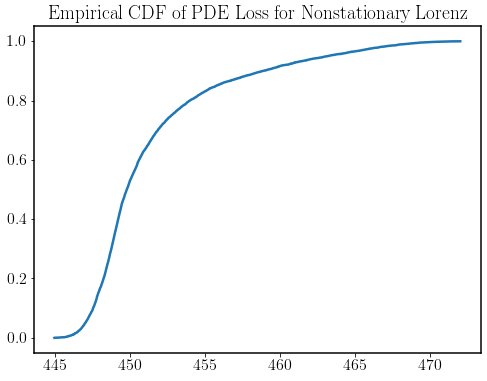

In [218]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(pde_loss_samples), np.linspace(0, 1, len(pde_loss_samples), endpoint=False))
plt.title("Empirical CDF of PDE Loss for Nonstationary Lorenz")
plt.show()

# DKW analysis

We would like to bound the location of the true CDF $F(x)$ within some interval $F_n(x) - \varepsilon \leq F(x) \leq F_n(x) + \varepsilon$ of the empirical CDF $F_n(x)$ for all $x$. In fact, using the DKW inequality, we find that with probability $1 - \beta$, the true CDF $F(x)$ differs by at most $\varepsilon$ from $F_n(x)$.

In particular, the DKW inequality tells us that $$\varepsilon = \sqrt{\frac{\ln \frac{2}{\beta}}{2n}}.$$

In [219]:
beta = 1e-3

In [220]:
eps = np.sqrt(np.log(2 / beta) / (2 * len(pde_loss_samples)))
print(eps)

0.023013165824156943


When predicting whether a tipping point has occurred, we would like to "call" a tipping point if the lower bound of the DKW inequality is greater than $1-\alpha$, for some significance value $\alpha$. That is, we call a tipping point if and only if $F_n(x) - \varepsilon > 1-\alpha \iff \alpha > 1 - F_n(x) + \varepsilon$.

In [221]:
alpha = eps

# Predicting tipping points

In [185]:
traj = test[0]

with torch.no_grad():
    t_mins = np.arange(T1, T2, T * dt)[:traj.shape[0]] + n_intervals * T * dt

    u = model.predict(traj, comp_steps)
    u = u.reshape((traj.shape[0], -1, dim))

    loss = PDE_loss(u, t_mins, dt).numpy()

In [252]:
print("Offset from start caused by composing model:", comp_offset)

Offset from start caused by composing model: 64.0


In [253]:
tipping_time = np.inf
t_mins = np.arange(T1, T2, T * dt)[:traj.shape[0]] + n_intervals * T * dt # n_intervals warm up time

for loss_val, time in zip(loss, t_mins):
    if alpha >= 1 - ecdf(loss_val) + eps:
        tipping_time = time
        break

if tipping_time != np.inf:
    print("Predicted tipping point: %.2f" % tipping_time)
else:
    print("No tipping point found")

Predicted tipping point: -23.04


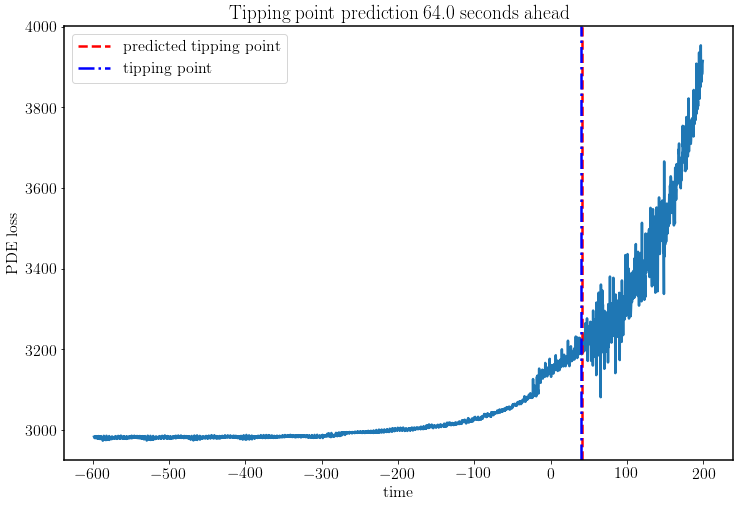

In [254]:
plt.figure(figsize=(12,8))
plt.plot(t_mins, loss)
plt.axvline(x = tipping_time + comp_offset, color='r', ls='--', label = 'predicted tipping point')
plt.axvline(x = tipping_point, color='b', ls='-.', label = 'tipping point')
plt.title("Tipping point prediction {} seconds ahead".format(comp_steps * dt * T))
plt.xlabel('time')
plt.ylabel('PDE loss')
plt.legend()
plt.show()

In [255]:
print("Error in tipping point prediction: %.2f" % ((tipping_time + comp_offset) - tipping_point))

Error in tipping point prediction: 0.96


# Paper Figures

### Figure 1

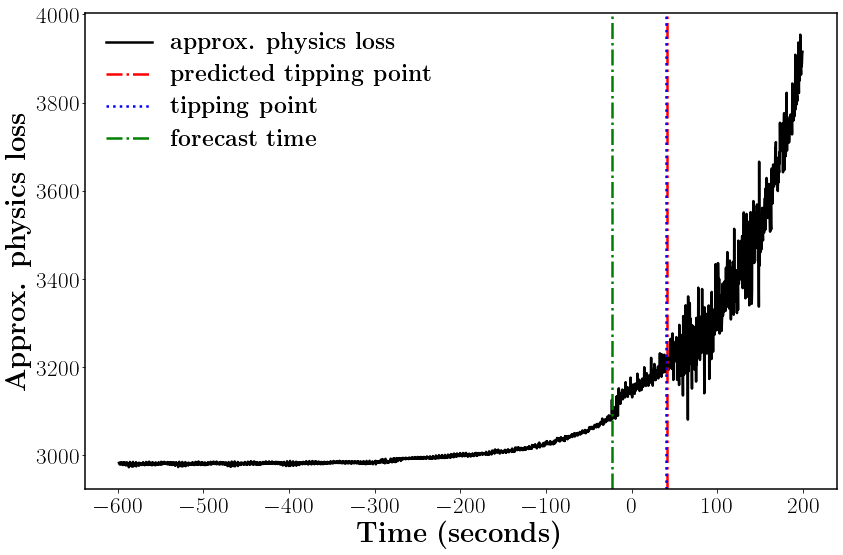

In [256]:
from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

# Set figure size and create the plot
plt.figure(figsize=(12, 8))

# Plot the data
plt.plot(t_mins, loss, color='black', label=r'\textbf{approx. physics loss}')
plt.axvline(x=tipping_time + comp_offset, color='r', ls='-.', label=r'\textbf{predicted tipping point}')
plt.axvline(x=tipping_point, color='b', ls='dotted', label=r'\textbf{tipping point}')
plt.axvline(x=tipping_time, color='green', ls='-.', label=r'\textbf{forecast time}')

# Set title and labels
#plt.title(r'\textbf{RNO tipping point prediction ' + str(comp_steps * dt * T) + ' seconds ahead}', fontsize='x-large')
plt.xlabel(r'\textbf{Time (seconds)}', fontsize='xx-large')
plt.ylabel(r'\textbf{Approx. physics loss}', fontsize='xx-large')

# Customize legend
legend = plt.legend(loc='best', fontsize='x-large', frameon=False)
legend.get_frame().set_linewidth(0)

# Adjust tick label size
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')

# Show the plot
plt.tight_layout()
plt.show()

### Figure 2

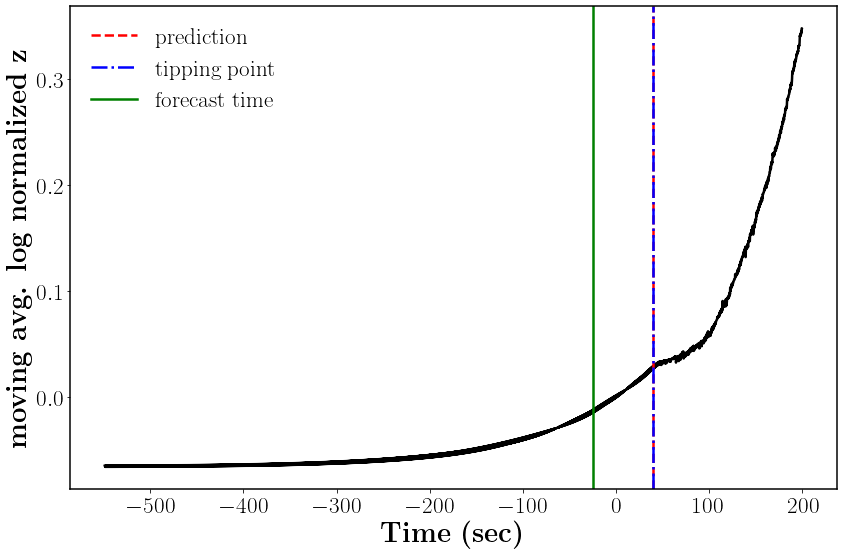

In [25]:
test_idx = 0
plot_dim = 2
coordinate = ['x', 'y', 'z'][plot_dim]

sliding_window_length = 10000

from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

# Set figure size and create the plot
temp = torch.reshape(test[test_idx,:,-1], (-1, dim)).numpy()
t = np.arange(T1, T2, dt)[:temp.shape[0]] + (n_intervals - 1) * T * dt

# Scale
broadcast_max = np.broadcast_to(train_max, temp.shape)
broadcast_min = np.broadcast_to(train_min, temp.shape)
temp = (temp - broadcast_min) / (broadcast_max - broadcast_min)

temp = np.log(temp)
temp = temp - np.mean(temp[:, plot_dim])
temp = temp[:,plot_dim]

temp = np.convolve(temp, np.ones(sliding_window_length), 'valid') / sliding_window_length
t = t[(t.shape[0] - temp.shape[0]):]
#t = t[:-(t.shape[0] - temp.shape[0])]

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))
line1 = ax1.plot(t, temp, 'black')
ax1.set_xlabel(r'\textbf{Time (sec)}', fontsize='xx-large')
ax1.set_ylabel(r'\textbf{moving avg. log normalized ' + coordinate + '}', fontsize='xx-large')
ax1.tick_params(labelsize='x-large')

line3 = ax1.axvline(x = tipping_time + comp_offset, color='r', ls='--', label = 'prediction')
line4 = ax1.axvline(x = tipping_point, color='b', ls='-.', label = 'tipping point')
line5 = ax1.axvline(x = tipping_time, color='g', ls='-', label = 'forecast time')

# Legend -- inspired from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = [line3] + [line4] + [line5]
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='best', fontsize='x-large')
legend.get_frame().set_linewidth(0)

# Show the plot
plt.tight_layout()

#plt.savefig('moving_avg_log_normalized_' + coordinate + '.pdf', format='pdf')
plt.show()

In [50]:
print("Sliding window length", sliding_window_length * dt)

Sliding window length 50.0
